## Визуализация CNN: Как нейросеть видит кошку

Нейронная сеть, предварительно обученная на ImageNet, способна распознавать любой из 1000 различных классов объектов. Например, кошек разных пород. Было бы интересно посмотреть, как выглядит **идеальная сиамская кошка** для нейронной сети.

> Конечно, вы можете заменить *siamese cat* на любой другой класс ImageNet.

Для начала загрузим VGG сеть:  

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from PIL import Image
import json
np.set_printoptions(precision=3,suppress=True)

model = keras.applications.VGG16(weights='imagenet',include_top=True)
classes = json.loads(open('imagenet_classes.json','r').read())

FileNotFoundError: [Errno 2] No such file or directory: 'imagenet_classes.json'

## Оптимизация для минимизации ошибки

Чтобы визуализировать идеальную кошку, мы начнем со случайного шума и попытаемся использовать  оптимизацию методом градиентного спуска, чтобы подстроить входное изображение таким образом, чтобы класс стал ближе к целевому.

Вот наше начальное изображение:

In [2]:
x = tf.Variable(tf.random.normal((1,224,224,3)))

def normalize(img):
    return (img-tf.reduce_min(img))/(tf.reduce_max(img)-tf.reduce_min(img))

plt.imshow(normalize(x[0]))

: 

: 

> Мы используем функцию `normalize`, чтобы привести наши значения в диапазон 0-1.

Если мы применим сеть VGG к этому изображению, то получим более или менее случайное распределение вероятностей:

2022-06-17 13:29:02.100818: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-06-17 13:29:02.570980: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Predicted class: 669 (mosquito net)
Probability of predicted class = 0.05466596782207489


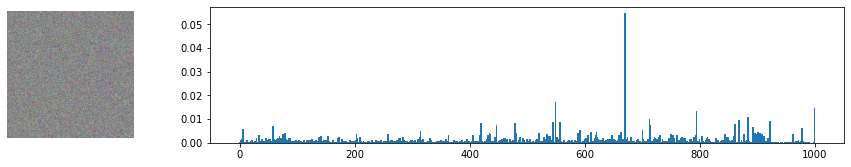

In [3]:
def plot_result(x):
    res = model(x)[0]
    cls = tf.argmax(res)
    print(f"Predicted class: {cls} ({classes[cls]})")
    print(f"Probability of predicted class = {res[cls]}")
    fig,ax = plt.subplots(1,2,figsize=(15,2.5),gridspec_kw = { "width_ratios" : [1,5]} )
    ax[0].imshow(normalize(x[0]))
    ax[0].axis('off')
    ax[1].bar(range(1000),res,width=3)
    plt.show()

plot_result(x)

> Несмотря на то, что может показаться, что вероятность одного из классов намного выше, чем у других, она все еще очень низкая - посмотрите на шкалу, чтобы увидеть, что фактическая вероятность все еще составляет около 5%.

Теперь давайте выберем одну целевую категорию (например, **сиамская кошка**), и начнем настраивать изображение с помощью градиентного спуска. Если $x$ — входное изображение, а $V$ — сеть VGG, мы рассчитаем функцию потерь $\mathcal{L} = \mathcal{L}(c,V(x))$ (где $c$ — целевая категория) и настроим $x$ по следующей формуле:
$$
x^{(i+1)} = x^{(i)} - \eta{\partial \mathcal{L}\over\partial x}
$$

В качестве функции потерь мы используем cross-entropy loss, поскольку мы сравниваем два распределения вероятностей. В нашем случае, поскольку класс представлен числом, то это будет Sparse Categorical Cross-Entropy.

Мы будем повторять этот процесс в течение нескольких эпох, печатая изображение по ходу дела.

> Лучше выполнить этот код на GPU или уменьшить количество эпох, чтобы минимизировать время ожидания.

Epoch: 900, loss: 0.5220473408699036


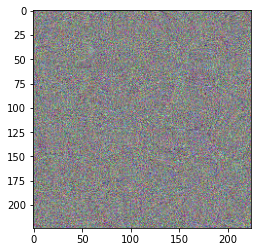

In [4]:
target = [284] # Siamese cat

def cross_entropy_loss(target,res):
    return tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res))

def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss, eta=1.0):
    if show_every is None:
        show_every = epochs // 10
    for i in range(epochs):
        with tf.GradientTape() as t:
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            x.assign_sub(eta*grads)
            if i%show_every == 0:
                clear_output(wait=True)
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(normalize(x[0]))
                plt.show()

optimize(x,target)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.6449142098426819


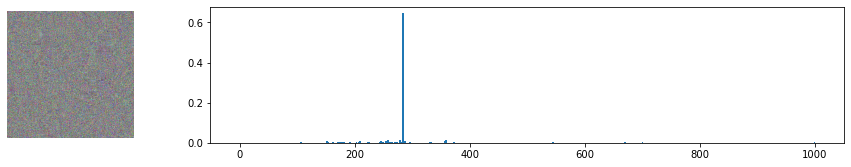

In [5]:
plot_result(x)

Мы получили изображение, которое выглядит как кошка для нейронной сети, хотя оно все еще выглядит как шум для нас. Если мы оптимизируем немного дольше - мы, скорее всего, получим образ **идеального шумного кота**, который имеет вероятность, близкую к 1.

## Осмысление шума

Этот шум не имеет для нас большого смысла, но, скорее всего, он содержит много низкоуровневых фильтров, которые характерны для кошки. Однако, поскольку существует очень много способов оптимизации входных данных для идеального результата, алгоритм оптимизации не мотивирован на поиск шаблонов, которые визуально понятны.

Чтобы это выглядело немного менее похожим на шум, мы можем ввести дополнительное слагаемое к функции потерь - **variation loss**. Он измеряет, насколько похожи соседние пиксели изображения. Если мы добавим variation loss к нашей *функции потерь*, это заставит оптимизатор находить решения с меньшим шумом и, таким образом, с более узнаваемыми деталями.

> На практике, чтобы получить хорошие результаты, нам нужно балансировать между cross-entropy loss и variation loss. Мы вводим некоторые числовые коэффициенты, и вы изменять их и наблюдать, как меняется изображение.

Epoch: 900, loss: [27.257]


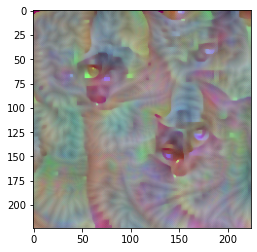

In [6]:
def total_loss(target,res):
    return 10*tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res)) + \
           0.005*tf.image.total_variation(x,res)

optimize(x,target,loss_fn=total_loss)

Это идеальный образ кошки для нашей нейронной сети, и мы даже можем увидеть некоторые знакомые черты, такие как глаза и уши. Их много, что делает нейронную сеть еще более уверенной в том, что это кошка.

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.9201651215553284


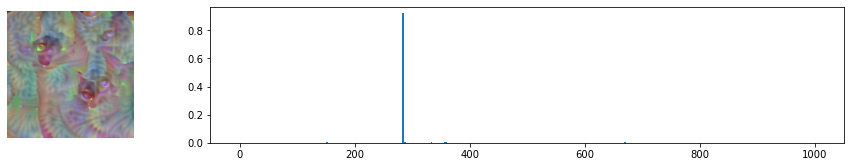

In [7]:
plot_result(x)

Давайте также посмотрим, как выглядит какой-то другой объект для VGG:

Epoch: 900, loss: [29.59]


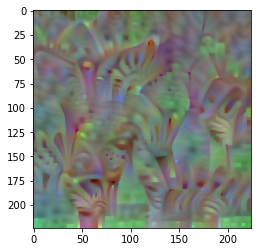

In [8]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,[340],loss_fn=total_loss) # zebra

## Атаки на нейросети (Adversarial Attacks)

Поскольку изображение *идеальной кошки* может выглядеть как случайный шум, это говорит о том, что мы можем взять любое изображение и слегка изменить его, чтобы оно классифицировалось как другой класс. Давайте немного поэкспериментируем с этим. Начнем с изображения собаки:

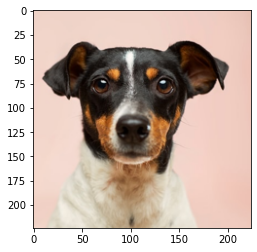

In [9]:
img = Image.open('images/dog-from-unsplash.jpg')
img = img.crop((200,20,600,420)).resize((224,224))
img = np.array(img)
plt.imshow(img)

Мы видим, что на этом изображении отчетливо распознается собака:

Predicted class: 171 (Italian greyhound)
Probability of predicted class = 0.9281901121139526


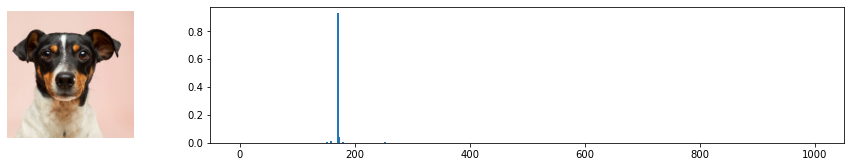

In [10]:
plot_result(np.expand_dims(img,axis=0))

Теперь, используем это изображение в качестве отправной точки и попробуем оптимизировать его, чтобы оно стало кошкой:

Epoch: 90, loss: 0.15769274532794952


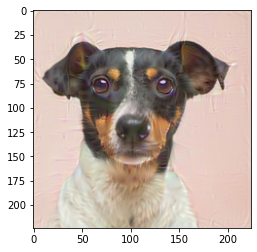

In [11]:
x = tf.Variable(np.expand_dims(img,axis=0).astype(np.float32)/255.0)
optimize(x,target,epochs=100)

Predicted class: 284 (Siamese cat, Siamese)
Probability of predicted class = 0.8651191592216492


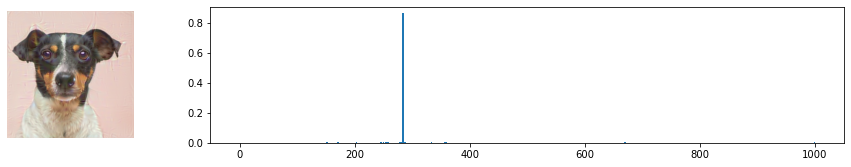

In [12]:
plot_result(x)

Получившееся изображение является идеальным котом с точки зрения сети VGG!

## Эксперименты с ResNet

Давайте теперь посмотрим, как это же изображение классифицируется другой моделью, скажем, ResNet:

In [13]:
model = keras.applications.ResNet50(weights='imagenet',include_top=True)

> Поскольку мы использовали `model` в качестве глобальной переменной, отныне все функции будут использовать ResNet вместо VGG

Predicted class: 111 (nematode, nematode worm, roundworm)
Probability of predicted class = 0.13089127838611603


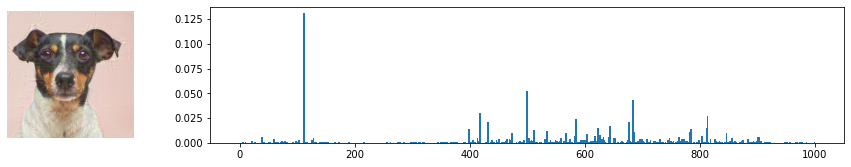

In [14]:
plot_result(x)

Ожидаемо, результат совсем другой - ведь при оптимизации под кота мы учитывали конкретную сеть VGG, ее низкоуровневые фильтры и т.д. Поскольку ResNet имеет другие фильтры, она дает другие результаты. Это дает нам представление о том, как мы можем защитить себя от состязательных атак - используя ансамбль различных моделей.

Давайте посмотрим, как выглядит идеальная зебра для ResNet:

Epoch: 450, loss: [46.166]


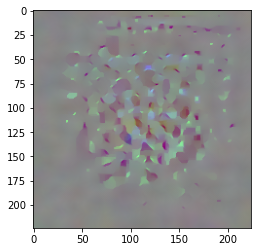

In [15]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
optimize(x,target=[340],epochs=500,loss_fn=total_loss)

Predicted class: 340 (zebra)
Probability of predicted class = 0.8876020312309265


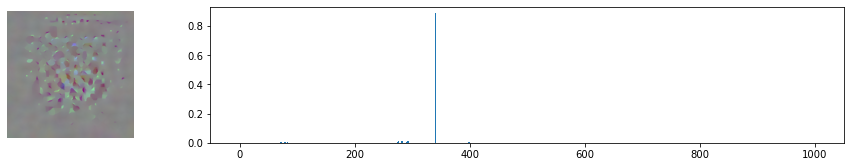

In [16]:
plot_result(x)

Эта картина совсем другая, а это значит, что архитектура нейронной сети играет довольно важную роль в том, как она распознает объекты.

> **Задание**: Попробуйте выполнить состязательное присоединение в ResNet и сравните результаты.

## Использование различных оптимизаторов

В нашем примере мы использовали простейшую технику оптимизации - градиентный спуск. Однако фреймворк Keras содержит различные встроенные [оптимизаторы](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), и мы можем использовать их вместо градиентного спуска. Это потребует очень небольших изменений в нашем коде - мы заменим часть, где мы корректируем входное изображение `x.assign_sub(eta*grads)` вызовом функции `apply_gradients` оптимизатора:

Epoch: 900, loss: [41.451]


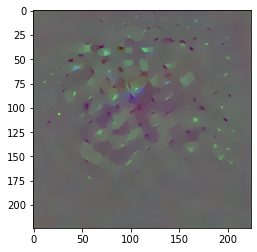

In [17]:
def optimize(x,target,epochs=1000,show_every=None,loss_fn=cross_entropy_loss,optimizer=keras.optimizers.SGD(learning_rate=1)):
    if show_every is None:
        show_every = epochs // 10
    for i in range(epochs):
        with tf.GradientTape() as t:
            res = model(x)
            loss = loss_fn(target,res)
            grads = t.gradient(loss,x)
            optimizer.apply_gradients([(grads,x)])
            if i%show_every == 0:
                clear_output(wait=True)
                print(f"Epoch: {i}, loss: {loss}")
                plt.imshow(normalize(x[0]))
                plt.show()

x = tf.Variable(tf.random.normal((1,224,224,3)))

optimize(x,[898],loss_fn=total_loss) # water bottle

## Заключение

Мы смогли визуализировать идеальное изображение кошки (а также любых других объектов) в рамках предварительно обученной CNN, используя оптимизацию методом градиентного спуска для подстройки входного изображения вместо весов. Основным трюком для получения изображения, которое имеет какой-то смысл, было использование variation loss в качестве дополнительной функции потерь, которая заставляет изображение выглядеть более гладким. 